$$\textbf{Machine Learning. Tarea 1: Métodos de descenso para Funciones de base radial}$$
$$\textit{Y. Sarahi García Gozález}$$

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import time


<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$

In [61]:
print("Tarea realizada en MacOs. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)



Tarea realizada en MacOs. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.11.5
NumPy version: 1.23.5
Pandas version: 2.1.4


<font size=4 color='mediumslateblue'>  

$\textit{Prepocesamiento de la imagen}$

In [62]:
imagen = cv2.imread("chefsito.png")
img_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

Dimensiones de la imagen:  (168, 168)


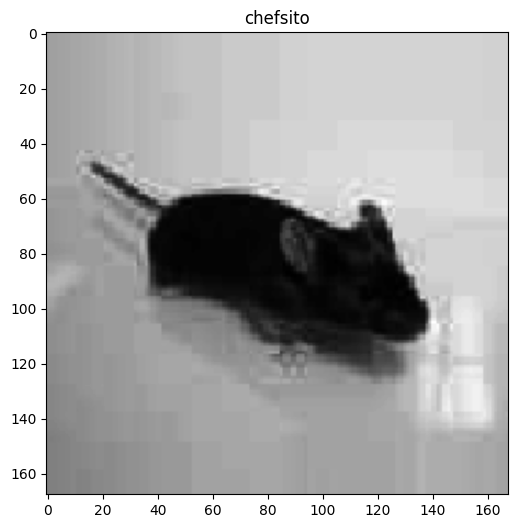

In [63]:
#Dimensiones de la imagen
print("Dimensiones de la imagen: " ,img_gris.shape) # (256, 256)
#mostramos la imagen
plt.figure(figsize=(6, 6))
plt.imshow(img_gris,cmap='gray')
plt.title('chefsito')
plt.show()

Redimensionamos a shape para reducir el numero de parametros

In [6]:
shape=32
im = cv2.resize(img_gris, (shape,shape))

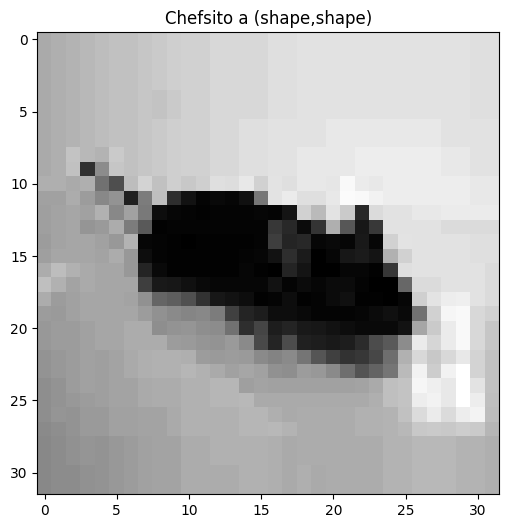

In [7]:
#Imprimimos con las nuevas dimensiones y con la normalización aplicada
plt.figure(figsize=(6, 6))
plt.imshow(im, cmap='gray')
plt.title('Chefsito a (shape,shape)')
plt.show()

In [8]:
#Normalizamos
im = im/255
im

array([[0.29803922, 0.30588235, 0.31372549, ..., 0.39215686, 0.38823529,
        0.38823529],
       [0.29803922, 0.30588235, 0.31372549, ..., 0.39215686, 0.38823529,
        0.38823529],
       [0.29803922, 0.30588235, 0.31372549, ..., 0.39215686, 0.38823529,
        0.38823529],
       ...,
       [0.23921569, 0.24705882, 0.25490196, ..., 0.31372549, 0.31372549,
        0.30588235],
       [0.23921569, 0.24705882, 0.24705882, ..., 0.31372549, 0.31372549,
        0.30588235],
       [0.23921569, 0.24705882, 0.24705882, ..., 0.31372549, 0.31372549,
        0.30588235]])

In [9]:
#convertimos a vector
objetivo = im.flatten()

In [10]:
objetivo.shape

(1024,)

In [11]:
objetivo

array([0.29803922, 0.30588235, 0.31372549, ..., 0.31372549, 0.31372549,
       0.30588235])

Buscamos aproximar la imagen pensandola como una función $f$ que a cada pixel $x=(x_1,x_2)$ le asigna un valor entre 0 y 1. Dicha aproximación se hará mediante una suma de funciones:

$$f(x) = \sum_{j=1}^J \alpha_j \phi(x; \theta_j) + \eta(x) $$ 

con $\eta(x)$ un residual

<font size=4 color='mediumslateblue'>  

$\textit{Funciones radiales base y derivadas}$

In [12]:
# Definición de laa funciones base 
def f_multiquadric(r, kappa):
    return np.sqrt(r**2 + kappa)

def f_gaussian(r, kappa):
    return np.exp(-kappa * r**2)

In [13]:
# Derivadas de las funciones base
def D_gaussian(alpha, x, theta, k):
    norma = np.linalg.norm(theta - x)
    derivada = np.array([x[0] - theta[0], x[1] - theta[1]])
    z = -2 * alpha * k * np.exp(-k * norma**2) * derivada
    return z

def D_multiquadric(alpha, x, theta, k):
    norma = np.linalg.norm(theta - x)
    derivada = np.array([x[0] - theta[0], x[1] - theta[1]])
    return alpha * (-2 * norma) / np.sqrt(norma**2 + k) * derivada

<font size=4 color='mediumslateblue'>  

$\textit{Parte 1: Paso lineal}$

En esta secció se ejemplifica como se calcula la aproximación sólo usando la parte lineal

In [50]:
# Inicializar centros aleatoriamente
J = 200  # Número de funciones radiales
centros = np.random.uniform(0, 1, (J, 2))

In [51]:
def get_phi(coordenadas, theta, funcion_radial, k):
    #Inicializamos la matriz en ceros
    Matriz_phi = np.zeros((len(coordenadas), len(theta)))

    #Iteramos sobre la coordnada de cada pixel
    for i in range(len(coordenadas)):
        #Iteramos sobre los theta
        for j in range(len(theta)):
            #Calculamos la distancia entre el punto y el centro
            r = np.linalg.norm(coordenadas[i] - theta[j])
            #Calculamos el valor de la función radial para la distancia r
            Matriz_phi[i,j] = funcion_radial(r,k)

    return Matriz_phi

In [52]:
x = np.array([(i, j) for i in range(shape) for j in range(shape)])
kappa_g =0.001
kappa_m = 0.0001
phi_multiquadric = get_phi(x, centros, f_multiquadric, kappa_m)
phi_gaussian = get_phi(x, centros,f_gaussian, kappa_g)


In [53]:
phi_multiquadric.shape

(1024, 200)

In [54]:
phi_gaussian.shape

(1024, 200)

In [55]:
#Coeficientes alpha para el modelo.
def get_alpha(objetivo, matriz_phi):

    # Calcula la pseudoinversa de Moore-Penrose de phi
    phi_pseudoinv = np.linalg.pinv(matriz_phi)
    # Resuelve el sistema utilizando la pseudoinversa de Moore-Penrose
    alpha = np.dot(phi_pseudoinv, objetivo)
    return alpha

In [56]:
alpha_multiquadric = get_alpha(objetivo,phi_multiquadric)
alpha_gaussian = get_alpha(objetivo,phi_gaussian)

In [57]:
aproximacion_multiquadric=phi_multiquadric@alpha_multiquadric
aproximacion_gaussian=phi_gaussian@alpha_gaussian

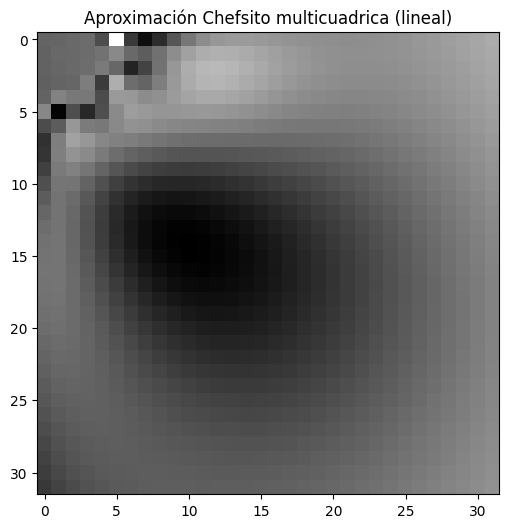

In [58]:

# Reshape the approximation matrix to a 256x256 matrix
matriz = np.reshape(aproximacion_multiquadric, (shape, shape))

# Scale the matrix to values between 0 and 255 (0 corresponds to black and 255 to white)
matriz = (matriz - np.min(matriz)) / (np.max(matriz) - np.min(matriz)) * 255

# Convert the matrix to an integer data type
matriz = matriz.astype(np.uint8)

# Convert the grayscale image matrix to a BGR image
imagen = cv2.cvtColor(matriz, cv2.COLOR_GRAY2BGR)


plt.figure(figsize=(6, 6))
plt.imshow(imagen , cmap='gray')
plt.title('Aproximación Chefsito multicuadrica (lineal)')
plt.show()

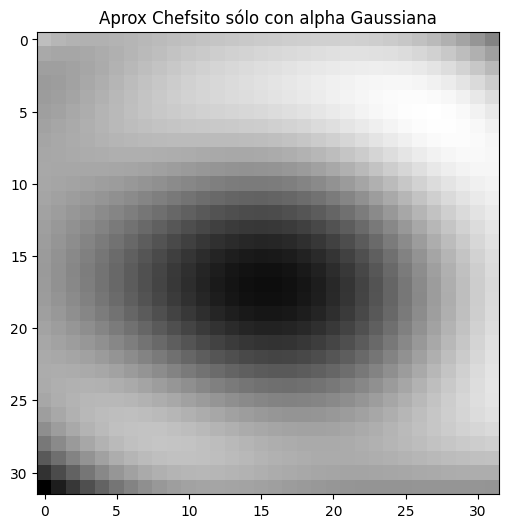

In [59]:
# Reshape the approximation matrix to a 256x256 matrix
matriz = np.reshape(aproximacion_gaussian, (shape, shape))

# Scale the matrix to values between 0 and 255 (0 corresponds to black and 255 to white)
matriz = (matriz - np.min(matriz)) / (np.max(matriz) - np.min(matriz)) * 255

# Convert the matrix to an integer data type
matriz = matriz.astype(np.uint8)

# Convert the grayscale image matrix to a BGR image
imagen = cv2.cvtColor(matriz, cv2.COLOR_GRAY2BGR)


plt.figure(figsize=(6, 6))
plt.imshow(imagen , cmap='gray')
plt.title('Aprox Chefsito sólo con alpha Gaussiana')
plt.show()

<font size=4 color='mediumslateblue'>  

$\textit{Parte 2}$

Función que calcula gradiente de phi:

In [24]:
def get_grad_phi(x, alpha, theta, objetivo, funcion_radial, grad_f_radial, k):
    phi = get_phi(x, theta, funcion_radial, k)
    M = phi @ alpha
    gradiente = np.zeros(theta.shape)

    for i in range(len(theta)):
        for j in range(len(x)):
            z = (objetivo[j] - M[j]) * grad_f_radial(alpha[i], x[j], theta[i], k)
            #Actualizamos el gradiente
            gradiente[i] = gradiente[i] + z

    return gradiente




Funció que optimiza simultánemaente los parámetros alpha y theta:

In [25]:
def optimiza_alpha_theta(optimizador,theta_inicial, maxIter, learning_rate, coordenadas, alpha_inicial, objrtivo, f_base, grad_f_base, k):

    theta = theta_inicial
    alpha = alpha_inicial

    for i in range(10):

        start_time_iter = time.time()
        # Paso I: Resuelve para alpha asumiendo theta fijo
        Phi_theta = get_phi(coordenadas, theta, f_base, k)
        alpha = get_alpha(objrtivo, Phi_theta)

        # Paso II: Actualiza theta utilizando descenso de gradiente
        theta, norm_grad = optimizador(theta, maxIter, learning_rate, coordenadas, alpha, objrtivo, f_base, grad_f_base, k)

        end_time_iter = time.time()
        time_iter = end_time_iter - start_time_iter
        #imprimimo num de iterqcion y tiempo 
        print(f"Iteración {i+1}/10- Tiempo : {time_iter:.4f} segundos - Norma gradiente: {norm_grad:.8f}")

    return theta, alpha

Optimizadores

In [26]:
def GD(theta_inicial, maxIter, learning_rate, coordenadas, alpha_inicial, objetivo, f_base, grad_f_base, k):
    theta = theta_inicial
    alpha = alpha_inicial


    for i in range(maxIter):
        gradiente = get_grad_phi(coordenadas, alpha, theta, objetivo, f_base, grad_f_base, k)        
        theta -= learning_rate * gradiente
        
    return theta,np.linalg.norm(gradiente)

In [27]:
def ADAM(theta_inicial, maxIter, learning_rate, coordenadas, alpha_inicial, objetivo, f_base, grad_f_base, k, beta1=0.9, beta2=0.999, epsilon=1e-8):
    theta = theta_inicial
    alpha = alpha_inicial

    m = np.zeros(theta.shape)
    v = np.zeros(theta.shape)
    t = 0

    for i in range(maxIter):
        t += 1
        gradiente = get_grad_phi(coordenadas, alpha, theta, objetivo, f_base, grad_f_base, k)
        
        m = beta1 * m + (1 - beta1) * gradiente
        v = beta2 * v + (1 - beta2) * (gradiente ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    return theta, np.linalg.norm(gradiente)

In [28]:
def Nesterov(theta_inicial, maxIter, learning_rate, coordenadas, alpha_inicial, objetivo, f_base, grad_f_base, k, mu=0.9):
    theta = theta_inicial
    alpha = alpha_inicial
    v = np.zeros(theta.shape)

    for i in range(maxIter):
        theta_ahead = theta - mu * v
        gradiente = get_grad_phi(coordenadas, alpha, theta_ahead, objetivo, f_base, grad_f_base, k)
        v = mu * v + learning_rate * gradiente
        theta -= v

    return theta, np.linalg.norm(gradiente)

Función que muestra la imagen aproximación

In [29]:
def genera_imagen_aproximada(theta,alpha,f_radial,kappa,title):
    phi = get_phi(x, theta, f_radial, kappa)
    aproximacion=phi@alpha

    # Reshape the approximation matrix to a 32x32 matrix
    matriz = np.reshape(aproximacion, (shape, shape))

    # Scale the matrix to values between 0 and 255 (0 corresponds to black and 255 to white)
    matriz = (matriz - np.min(matriz)) / (np.max(matriz) - np.min(matriz)) * 255

    # Convert the matrix to an integer data type
    matriz = matriz.astype(np.uint8)

    # Convert the grayscale image matrix to a BGR image
    imagen = cv2.cvtColor(matriz, cv2.COLOR_GRAY2BGR)


    plt.figure(figsize=(6, 6))
    plt.imshow(imagen , cmap='gray')
    plt.title("aproximación chefcito con " + title)
    plt.show()

<font size=4 color='mediumslateblue'>  

$\textit{Resultados Multicuadrica}$

<font size=2 color='mediumslateblue'>  

$\textit{GD}$

In [30]:
# Inicializar centros aleatoriamente
J = 200  # Número de funciones radiales
centros = np.random.uniform(1, shape, (J, 2))
#coordenadas
x = np.array([(I, j) for I in range(shape) for j in range(shape)])
phi_multiquadric = get_phi(x, centros, f_multiquadric, kappa_m)
alpha_multiquadric = get_alpha(objetivo,phi_multiquadric)
N=10
lr=0.0001
kappa_m = 1/(2*(3**2))
theta_multiquadric_GD,alpha_multiquadric_GD=optimiza_alpha_theta(GD,centros,N,lr,x,alpha_multiquadric,objetivo,f_multiquadric,D_multiquadric,kappa_m)

Iteración 1/10- Tiempo : 15.7900 segundos - Norma gradiente: 2.33901800
Iteración 2/10- Tiempo : 15.3987 segundos - Norma gradiente: 2.33872622
Iteración 3/10- Tiempo : 15.2904 segundos - Norma gradiente: 2.33843392
Iteración 4/10- Tiempo : 15.3383 segundos - Norma gradiente: 2.33814110
Iteración 5/10- Tiempo : 16.0837 segundos - Norma gradiente: 2.33784776
Iteración 6/10- Tiempo : 16.1277 segundos - Norma gradiente: 2.33755393
Iteración 7/10- Tiempo : 15.9628 segundos - Norma gradiente: 2.33725960
Iteración 8/10- Tiempo : 15.6865 segundos - Norma gradiente: 2.33696470
Iteración 9/10- Tiempo : 15.6511 segundos - Norma gradiente: 2.33666938
Iteración 10/10- Tiempo : 15.6072 segundos - Norma gradiente: 2.33637355


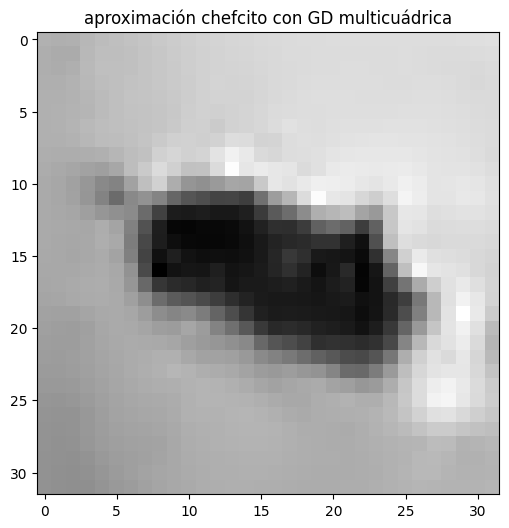

In [31]:
titulo="GD multicuádrica"
genera_imagen_aproximada(theta_multiquadric_GD,alpha_multiquadric_GD, f_multiquadric, kappa_m,titulo)

<font size=2 color='mediumslateblue'>  

$\textit{ADAM}$

In [32]:
# Inicializar centros aleatoriamente
J = 200  # Número de funciones radiales
centros = np.random.uniform(1, shape, (J, 2))
#coordenadas
x = np.array([(I, j) for I in range(shape) for j in range(shape)])
phi_multiquadric = get_phi(x, centros, f_multiquadric, kappa_m)
alpha_multiquadric = get_alpha(objetivo,phi_multiquadric)
N=10
lr=0.0001
kappa_m = 1/(2*(3**2))
theta_multiquadric_ADAM,alpha_multiquadric_ADAM=optimiza_alpha_theta(ADAM,centros,N,lr,x,alpha_multiquadric,objetivo,f_multiquadric,D_multiquadric,kappa_m)

Iteración 1/10- Tiempo : 15.5548 segundos - Norma gradiente: 40.05115384
Iteración 2/10- Tiempo : 15.7952 segundos - Norma gradiente: 40.02052209
Iteración 3/10- Tiempo : 16.1575 segundos - Norma gradiente: 39.98938683
Iteración 4/10- Tiempo : 15.8544 segundos - Norma gradiente: 39.95815239
Iteración 5/10- Tiempo : 15.6921 segundos - Norma gradiente: 39.92635671
Iteración 6/10- Tiempo : 15.6973 segundos - Norma gradiente: 39.89401523
Iteración 7/10- Tiempo : 15.7579 segundos - Norma gradiente: 39.86114376
Iteración 8/10- Tiempo : 15.3292 segundos - Norma gradiente: 39.82775833
Iteración 9/10- Tiempo : 15.5571 segundos - Norma gradiente: 39.79387579
Iteración 10/10- Tiempo : 15.5273 segundos - Norma gradiente: 39.75951277


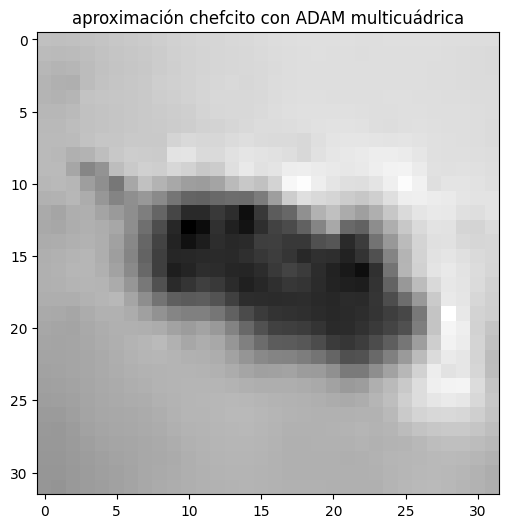

In [33]:
titulo="ADAM multicuádrica"
genera_imagen_aproximada(theta_multiquadric_ADAM,alpha_multiquadric_ADAM, f_multiquadric, kappa_m,titulo)

<font size=2 color='mediumslateblue'>  

$\textit{Nesterov}$

In [34]:
# Inicializar centros aleatoriamente
J = 200  # Número de funciones radiales
centros = np.random.uniform(1, shape, (J, 2))
#coordenadas
x = np.array([(I, j) for I in range(shape) for j in range(shape)])
phi_multiquadric = get_phi(x, centros, f_multiquadric, kappa_m)
alpha_multiquadric = get_alpha(objetivo,phi_multiquadric)
N=10
lr=0.0001
kappa_m = 1/(2*(3**2))
theta_multiquadric_nesterov,alpha_multiquadric_nesterov=optimiza_alpha_theta(Nesterov,centros,N,lr,x,alpha_multiquadric,objetivo,f_multiquadric,D_multiquadric,kappa_m)

Iteración 1/10- Tiempo : 16.0287 segundos - Norma gradiente: 109.20403213
Iteración 2/10- Tiempo : 16.0094 segundos - Norma gradiente: 108.42522019
Iteración 3/10- Tiempo : 15.6888 segundos - Norma gradiente: 107.72289848
Iteración 4/10- Tiempo : 15.5427 segundos - Norma gradiente: 107.11452652
Iteración 5/10- Tiempo : 15.5718 segundos - Norma gradiente: 106.61325670
Iteración 6/10- Tiempo : 15.3893 segundos - Norma gradiente: 106.22869826
Iteración 7/10- Tiempo : 15.5026 segundos - Norma gradiente: 105.96765819
Iteración 8/10- Tiempo : 15.3803 segundos - Norma gradiente: 105.83481890
Iteración 9/10- Tiempo : 15.4396 segundos - Norma gradiente: 105.83334302
Iteración 10/10- Tiempo : 15.2972 segundos - Norma gradiente: 105.96539631


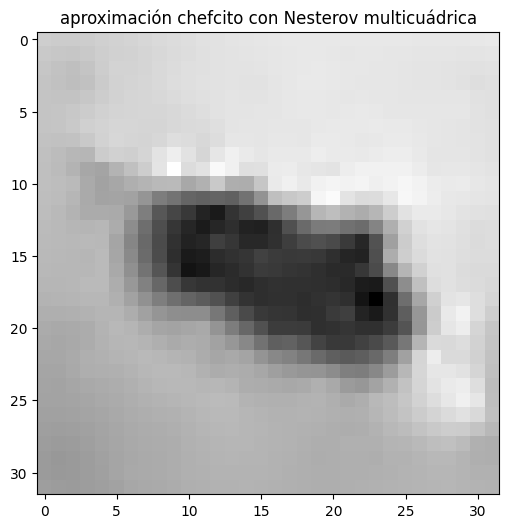

In [35]:
titulo="Nesterov multicuádrica"
genera_imagen_aproximada(theta_multiquadric_nesterov,alpha_multiquadric_nesterov, f_multiquadric, kappa_m,titulo)


<font size=4 color='mediumslateblue'>  

$\textit{Resultados Gauss}$

<font size=2 color='mediumslateblue'>  

$\textit{GD}$

In [36]:
# Inicializar centros aleatoriamente
J = 200  # Número de funciones radiales
centros = np.random.uniform(1, shape, (J, 2))
#coordenadas
x = np.array([(I, j) for I in range(shape) for j in range(shape)])
phi_gaussian = get_phi(x, centros, f_gaussian, kappa_m)
alpha_gaussian = get_alpha(objetivo,phi_gaussian)
N=10
lr=0.0001
kappa_m = 1/(2*(3**2))
theta_gaussian_GD,alpha_gaussian_GD=optimiza_alpha_theta(GD,centros,N,lr,x,alpha_gaussian,objetivo,f_gaussian,D_gaussian,kappa_m)

Iteración 1/10- Tiempo : 15.7791 segundos - Norma gradiente: 0.07394252
Iteración 2/10- Tiempo : 15.7943 segundos - Norma gradiente: 0.07394178
Iteración 3/10- Tiempo : 15.6799 segundos - Norma gradiente: 0.07394104
Iteración 4/10- Tiempo : 15.7415 segundos - Norma gradiente: 0.07394029
Iteración 5/10- Tiempo : 15.9597 segundos - Norma gradiente: 0.07393955
Iteración 6/10- Tiempo : 15.9260 segundos - Norma gradiente: 0.07393881
Iteración 7/10- Tiempo : 15.7707 segundos - Norma gradiente: 0.07393806
Iteración 8/10- Tiempo : 15.6657 segundos - Norma gradiente: 0.07393732
Iteración 9/10- Tiempo : 15.6245 segundos - Norma gradiente: 0.07393658
Iteración 10/10- Tiempo : 16.0394 segundos - Norma gradiente: 0.07393584


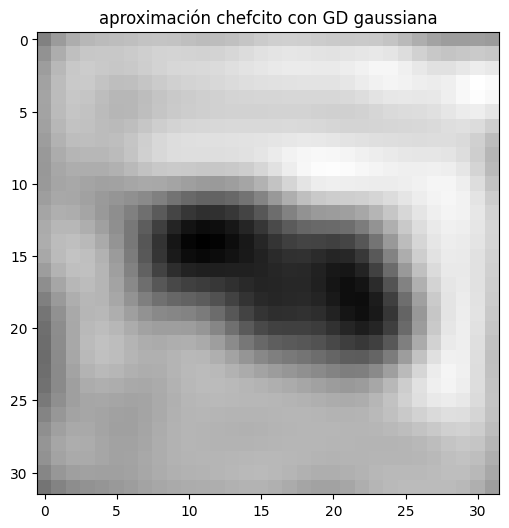

In [37]:
titulo="GD gaussiana"
genera_imagen_aproximada(theta_gaussian_GD,alpha_gaussian_GD, f_gaussian, kappa_m,titulo)

<font size=2 color='mediumslateblue'>  

$\textit{ADAM}$

In [38]:
# Inicializar centros aleatoriamente
J = 200  # Número de funciones radiales
centros = np.random.uniform(1, shape, (J, 2))
#coordenadas
x = np.array([(I, j) for I in range(shape) for j in range(shape)])
phi_gaussian = get_phi(x, centros, f_gaussian, kappa_m)
alpha_gaussian = get_alpha(objetivo,phi_gaussian)
N=10
lr=0.0001
kappa_m = 1/(2*(3**2))
theta_gaussian_ADAM,alpha_gaussian_ADAM=optimiza_alpha_theta(ADAM,centros,N,lr,x,alpha_gaussian,objetivo,f_gaussian,D_gaussian,kappa_m)

Iteración 1/10- Tiempo : 16.3609 segundos - Norma gradiente: 0.04440947
Iteración 2/10- Tiempo : 16.6969 segundos - Norma gradiente: 0.04434997
Iteración 3/10- Tiempo : 16.4768 segundos - Norma gradiente: 0.04429039
Iteración 4/10- Tiempo : 16.3680 segundos - Norma gradiente: 0.04422779
Iteración 5/10- Tiempo : 16.9324 segundos - Norma gradiente: 0.04416632
Iteración 6/10- Tiempo : 16.3082 segundos - Norma gradiente: 0.04410491
Iteración 7/10- Tiempo : 16.0519 segundos - Norma gradiente: 0.04404390
Iteración 8/10- Tiempo : 16.3554 segundos - Norma gradiente: 0.04398332
Iteración 9/10- Tiempo : 16.2893 segundos - Norma gradiente: 0.04392296
Iteración 10/10- Tiempo : 16.0164 segundos - Norma gradiente: 0.04386275


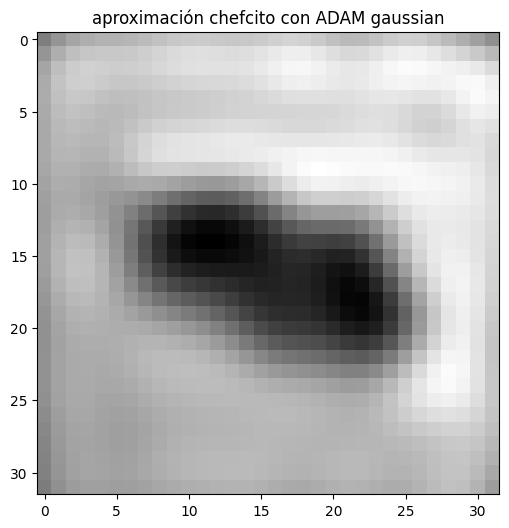

In [39]:
titulo="ADAM gaussian"
genera_imagen_aproximada(theta_gaussian_ADAM,alpha_gaussian_ADAM, f_gaussian, kappa_m,titulo)

<font size=2 color='mediumslateblue'>  

$\textit{Nesterov}$

In [40]:
# Inicializar centros aleatoriamente
J = 200  # Número de funciones radiales
centros = np.random.uniform(1, shape, (J, 2))
#coordenadas
x = np.array([(I, j) for I in range(shape) for j in range(shape)])
phi_gaussian = get_phi(x, centros, f_gaussian, kappa_m)
alpha_gaussian = get_alpha(objetivo,phi_gaussian)
N=10
lr=0.0001
kappa_m = 1/(2*(3**2))
theta_gaussian_nesterov,alpha_gaussian_nesterov=optimiza_alpha_theta(Nesterov,centros,N,lr,x,alpha_gaussian,objetivo,f_gaussian,D_gaussian,kappa_m)

Iteración 1/10- Tiempo : 16.2591 segundos - Norma gradiente: 0.17254302
Iteración 2/10- Tiempo : 16.1843 segundos - Norma gradiente: 0.17252100
Iteración 3/10- Tiempo : 16.2161 segundos - Norma gradiente: 0.17249899
Iteración 4/10- Tiempo : 17.9860 segundos - Norma gradiente: 0.17247699
Iteración 5/10- Tiempo : 16.2839 segundos - Norma gradiente: 0.17245501
Iteración 6/10- Tiempo : 16.0980 segundos - Norma gradiente: 0.17243304
Iteración 7/10- Tiempo : 16.9236 segundos - Norma gradiente: 0.17241108
Iteración 8/10- Tiempo : 16.7476 segundos - Norma gradiente: 0.17238913
Iteración 9/10- Tiempo : 17.0788 segundos - Norma gradiente: 0.17236720
Iteración 10/10- Tiempo : 17.5123 segundos - Norma gradiente: 0.17234527


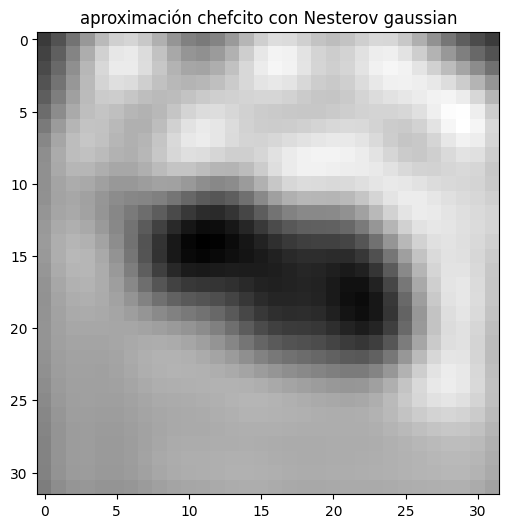

In [41]:
titulo="Nesterov gaussian"
genera_imagen_aproximada(theta_gaussian_nesterov,alpha_gaussian_nesterov, f_gaussian, kappa_m,titulo)